### Model_JX

+ attention

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class JXdataset(Dataset):
    def __init__(self, path):
        JX = pd.read_csv(path)
        JX_data = torch.tensor(JX.values, dtype=torch.float32)
        self.value, self.target = JX_data[:, :-1], JX_data[:, -1]
    
    def __getitem__(self, index):
        return self.value[index], self.target[index]

    def __len__(self):
        return len(self.value)
    

batch_size = 64

train_dataset = JXdataset("./jixie_train_data.csv")
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = JXdataset("./jixie_test_data.csv")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_func = nn.MSELoss()

In [2]:
# MultiheadAttention
class MHA(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality
        qkv = self.c_attn(x)
        # 使用chunk更清晰地将张量分成三等份
        q, k, v = qkv.chunk(3, dim=2)
        
        # 重塑为多头格式 [B, nh, T, hs]
        head_size = self.n_embd // self.n_head
        k = k.view(B, T, self.n_head, head_size).transpose(1, 2)
        q = q.view(B, T, self.n_head, head_size).transpose(1, 2)
        v = v.view(B, T, self.n_head, head_size).transpose(1, 2)

        # 计算注意力
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(head_size))
        att = F.softmax(att, dim=-1)
        y = att @ v
        
        # 重塑回原始形状
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        
        # 输出投影
        y = self.c_proj(y)
        return y

# 创建回归模型
class RegressionModel(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, n_head=4):
        super().__init__()
        # MHA配置
        self.config = type('Config', (), {
            'n_embd': hidden_dim,
            'n_head': n_head
        })
        
        # 输入嵌入
        self.input_embedding = nn.Linear(input_dim, hidden_dim)
        
        # MHA层
        self.mha = MHA(self.config)
        
        # 输出层
        self.output_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # x: [batch_size, input_features]
        x = x.unsqueeze(1)  # [batch_size, 1, input_features]
        x = self.input_embedding(x)  # [batch_size, 1, hidden_dim]
        x = self.mha(x)  # [batch_size, 1, hidden_dim]
        x = self.output_layer(x)  # [batch_size, 1, 1]
        x = x.squeeze(-1).squeeze(-1)  # [batch_size]
        return x

Epoch 1 Training: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s, loss=1.76e+4]


训练损失: 17643.809954
测试损失: 9170.434082


Epoch 2 Training: 100%|██████████| 7/7 [00:00<00:00, 285.00it/s, loss=4.88e+3]


训练损失: 4884.489267
测试损失: 3.109553


Epoch 3 Training: 100%|██████████| 7/7 [00:00<00:00, 279.89it/s, loss=1.98e+3]


训练损失: 1978.863813
测试损失: 631.119247


Epoch 4 Training: 100%|██████████| 7/7 [00:00<00:00, 251.30it/s, loss=1.11e+3]


训练损失: 1106.514574
测试损失: 867.024445


Epoch 5 Training: 100%|██████████| 7/7 [00:00<00:00, 220.06it/s, loss=611]


训练损失: 610.866683
测试损失: 735.435043


Epoch 6 Training: 100%|██████████| 7/7 [00:00<00:00, 235.64it/s, loss=329]


训练损失: 329.329903
测试损失: 389.839844


Epoch 7 Training: 100%|██████████| 7/7 [00:00<00:00, 285.62it/s, loss=159]


训练损失: 158.738190
测试损失: 111.531351


Epoch 8 Training: 100%|██████████| 7/7 [00:00<00:00, 319.47it/s, loss=67.3]


训练损失: 67.339752
测试损失: 1.929050


Epoch 9 Training: 100%|██████████| 7/7 [00:00<00:00, 237.50it/s, loss=28]


训练损失: 27.985940
测试损失: 16.632105


Epoch 10 Training: 100%|██████████| 7/7 [00:00<00:00, 289.45it/s, loss=17.8]


训练损失: 17.789250
测试损失: 24.357212


Epoch 11 Training: 100%|██████████| 7/7 [00:00<00:00, 308.80it/s, loss=10.5]


训练损失: 10.510588
测试损失: 3.895770


Epoch 12 Training: 100%|██████████| 7/7 [00:00<00:00, 284.19it/s, loss=3.59]


训练损失: 3.589696
测试损失: 1.108071


Epoch 13 Training: 100%|██████████| 7/7 [00:00<00:00, 298.48it/s, loss=2.2]


训练损失: 2.196256
测试损失: 3.215874


Epoch 14 Training: 100%|██████████| 7/7 [00:00<00:00, 304.83it/s, loss=1.4]


训练损失: 1.401805
测试损失: 0.157092


Epoch 15 Training: 100%|██████████| 7/7 [00:00<00:00, 314.48it/s, loss=0.518]


训练损失: 0.517926
测试损失: 0.581015


Epoch 16 Training: 100%|██████████| 7/7 [00:00<00:00, 304.70it/s, loss=0.395]


训练损失: 0.395214
测试损失: 0.247552


Epoch 17 Training: 100%|██████████| 7/7 [00:00<00:00, 313.47it/s, loss=0.173]


训练损失: 0.172771
测试损失: 0.160248


Epoch 18 Training: 100%|██████████| 7/7 [00:00<00:00, 287.30it/s, loss=0.139]


训练损失: 0.138764
测试损失: 0.085453


Epoch 19 Training: 100%|██████████| 7/7 [00:00<00:00, 262.06it/s, loss=0.117]


训练损失: 0.116609
测试损失: 0.104737


Epoch 20 Training: 100%|██████████| 7/7 [00:00<00:00, 192.52it/s, loss=0.124]


训练损失: 0.123712
测试损失: 0.089644


Epoch 21 Training: 100%|██████████| 7/7 [00:00<00:00, 229.03it/s, loss=0.109]


训练损失: 0.109331
测试损失: 0.144264


Epoch 22 Training: 100%|██████████| 7/7 [00:00<00:00, 216.90it/s, loss=0.12]


训练损失: 0.120118
测试损失: 0.099250


Epoch 23 Training: 100%|██████████| 7/7 [00:00<00:00, 231.86it/s, loss=0.12]


训练损失: 0.120017
测试损失: 0.086000


Epoch 24 Training: 100%|██████████| 7/7 [00:00<00:00, 218.40it/s, loss=0.112]


训练损失: 0.111816
测试损失: 0.089133


Epoch 25 Training: 100%|██████████| 7/7 [00:00<00:00, 228.20it/s, loss=0.11]


训练损失: 0.109716
测试损失: 0.085310


Epoch 26 Training: 100%|██████████| 7/7 [00:00<00:00, 186.04it/s, loss=0.105]


训练损失: 0.104667
测试损失: 0.084913


Epoch 27 Training: 100%|██████████| 7/7 [00:00<00:00, 195.72it/s, loss=0.105]


训练损失: 0.104633
测试损失: 0.115049


Epoch 28 Training: 100%|██████████| 7/7 [00:00<00:00, 172.62it/s, loss=0.111]


训练损失: 0.111115
测试损失: 0.114272


Epoch 29 Training: 100%|██████████| 7/7 [00:00<00:00, 174.22it/s, loss=0.106]


训练损失: 0.106207
测试损失: 0.085326


Epoch 30 Training: 100%|██████████| 7/7 [00:00<00:00, 176.12it/s, loss=0.102]


训练损失: 0.101735
测试损失: 0.086779


Epoch 31 Training: 100%|██████████| 7/7 [00:00<00:00, 186.70it/s, loss=0.102]


训练损失: 0.101911
测试损失: 0.085200


Epoch 32 Training: 100%|██████████| 7/7 [00:00<00:00, 190.82it/s, loss=0.104]


训练损失: 0.104090
测试损失: 0.086105


Epoch 33 Training: 100%|██████████| 7/7 [00:00<00:00, 152.35it/s, loss=0.103]


训练损失: 0.102835
测试损失: 0.084666


Epoch 34 Training: 100%|██████████| 7/7 [00:00<00:00, 148.59it/s, loss=0.105]


训练损失: 0.104857
测试损失: 0.084624


Epoch 35 Training: 100%|██████████| 7/7 [00:00<00:00, 157.84it/s, loss=0.105]


训练损失: 0.104539
测试损失: 0.091794


Epoch 36 Training: 100%|██████████| 7/7 [00:00<00:00, 199.59it/s, loss=0.105]


训练损失: 0.105382
测试损失: 0.087059


Epoch 37 Training: 100%|██████████| 7/7 [00:00<00:00, 185.76it/s, loss=0.106]


训练损失: 0.105944
测试损失: 0.091164


Epoch 38 Training: 100%|██████████| 7/7 [00:00<00:00, 171.66it/s, loss=0.104]


训练损失: 0.103840
测试损失: 0.122909


Epoch 39 Training: 100%|██████████| 7/7 [00:00<00:00, 160.83it/s, loss=0.112]


训练损失: 0.111887
测试损失: 0.135464


Epoch 40 Training: 100%|██████████| 7/7 [00:00<00:00, 182.62it/s, loss=0.11]


训练损失: 0.109615
测试损失: 0.089685


Epoch 41 Training: 100%|██████████| 7/7 [00:00<00:00, 190.98it/s, loss=0.105]


训练损失: 0.105398
测试损失: 0.099169


Epoch 42 Training: 100%|██████████| 7/7 [00:00<00:00, 170.89it/s, loss=0.104]


训练损失: 0.104149
测试损失: 0.087270


Epoch 43 Training: 100%|██████████| 7/7 [00:00<00:00, 202.27it/s, loss=0.103]


训练损失: 0.103427
测试损失: 0.085749


Epoch 44 Training: 100%|██████████| 7/7 [00:00<00:00, 200.09it/s, loss=0.103]


训练损失: 0.103000
测试损失: 0.086882


Epoch 45 Training: 100%|██████████| 7/7 [00:00<00:00, 184.88it/s, loss=0.105]


训练损失: 0.105308
测试损失: 0.086980


Epoch 46 Training: 100%|██████████| 7/7 [00:00<00:00, 172.36it/s, loss=0.104]


训练损失: 0.103967
测试损失: 0.084632


Epoch 47 Training: 100%|██████████| 7/7 [00:00<00:00, 185.63it/s, loss=0.114]


训练损失: 0.113708
测试损失: 0.118338


Epoch 48 Training: 100%|██████████| 7/7 [00:00<00:00, 198.04it/s, loss=0.126]


训练损失: 0.126232
测试损失: 0.127172


Epoch 49 Training: 100%|██████████| 7/7 [00:00<00:00, 192.07it/s, loss=0.109]


训练损失: 0.108857
测试损失: 0.102348


Epoch 50 Training: 100%|██████████| 7/7 [00:00<00:00, 200.85it/s, loss=0.118]


训练损失: 0.117842
测试损失: 0.147518


Epoch 51 Training: 100%|██████████| 7/7 [00:00<00:00, 181.99it/s, loss=0.121]


训练损失: 0.121434
测试损失: 0.150378


Epoch 52 Training: 100%|██████████| 7/7 [00:00<00:00, 179.01it/s, loss=0.114]


训练损失: 0.114421
测试损失: 0.099031


Epoch 53 Training: 100%|██████████| 7/7 [00:00<00:00, 211.43it/s, loss=0.105]


训练损失: 0.105000
测试损失: 0.116269


Epoch 54 Training: 100%|██████████| 7/7 [00:00<00:00, 186.07it/s, loss=0.111]


训练损失: 0.110618
测试损失: 0.092529


Epoch 55 Training: 100%|██████████| 7/7 [00:00<00:00, 164.81it/s, loss=0.102]


训练损失: 0.101866
测试损失: 0.090121


Epoch 56 Training: 100%|██████████| 7/7 [00:00<00:00, 174.74it/s, loss=0.101]


训练损失: 0.101299
测试损失: 0.087397


Epoch 57 Training: 100%|██████████| 7/7 [00:00<00:00, 170.03it/s, loss=0.104]


训练损失: 0.104281
测试损失: 0.094905


Epoch 58 Training: 100%|██████████| 7/7 [00:00<00:00, 167.16it/s, loss=0.117]


训练损失: 0.117479
测试损失: 0.091757


Epoch 59 Training: 100%|██████████| 7/7 [00:00<00:00, 152.41it/s, loss=0.109]


训练损失: 0.109216
测试损失: 0.088361


Epoch 60 Training: 100%|██████████| 7/7 [00:00<00:00, 162.06it/s, loss=0.115]


训练损失: 0.115193
测试损失: 0.096844


Epoch 61 Training: 100%|██████████| 7/7 [00:00<00:00, 172.81it/s, loss=0.109]


训练损失: 0.109452
测试损失: 0.083902


Epoch 62 Training: 100%|██████████| 7/7 [00:00<00:00, 177.71it/s, loss=0.101]


训练损失: 0.100998
测试损失: 0.085485


Epoch 63 Training: 100%|██████████| 7/7 [00:00<00:00, 170.11it/s, loss=0.101]


训练损失: 0.100703
测试损失: 0.094802


Epoch 64 Training: 100%|██████████| 7/7 [00:00<00:00, 192.71it/s, loss=0.11]


训练损失: 0.110331
测试损失: 0.092186


Epoch 65 Training: 100%|██████████| 7/7 [00:00<00:00, 246.79it/s, loss=0.104]

训练损失: 0.103875


测试损失: 0.087046


Epoch 66 Training: 100%|██████████| 7/7 [00:00<00:00, 195.12it/s, loss=0.105]

训练损失: 0.105145


测试损失: 0.087945


Epoch 67 Training: 100%|██████████| 7/7 [00:00<00:00, 165.42it/s, loss=0.108]


训练损失: 0.107718
测试损失: 0.083730


Epoch 68 Training: 100%|██████████| 7/7 [00:00<00:00, 193.13it/s, loss=0.103]


训练损失: 0.103207
测试损失: 0.086661


Epoch 69 Training: 100%|██████████| 7/7 [00:00<00:00, 176.99it/s, loss=0.102]


训练损失: 0.102196
测试损失: 0.083717


Epoch 70 Training: 100%|██████████| 7/7 [00:00<00:00, 189.02it/s, loss=0.101]


训练损失: 0.101330
测试损失: 0.085177


Epoch 71 Training: 100%|██████████| 7/7 [00:00<00:00, 205.60it/s, loss=0.1]


训练损失: 0.100332
测试损失: 0.085639


Epoch 72 Training: 100%|██████████| 7/7 [00:00<00:00, 205.46it/s, loss=0.101]


训练损失: 0.101236
测试损失: 0.084212


Epoch 73 Training: 100%|██████████| 7/7 [00:00<00:00, 170.72it/s, loss=0.103]


训练损失: 0.102804
测试损失: 0.086479


Epoch 74 Training: 100%|██████████| 7/7 [00:00<00:00, 177.90it/s, loss=0.103]


训练损失: 0.102640
测试损失: 0.102779


Epoch 75 Training: 100%|██████████| 7/7 [00:00<00:00, 196.00it/s, loss=0.106]


训练损失: 0.105952
测试损失: 0.091329


Epoch 76 Training: 100%|██████████| 7/7 [00:00<00:00, 206.64it/s, loss=0.129]


训练损失: 0.129318
测试损失: 0.084326


Epoch 77 Training: 100%|██████████| 7/7 [00:00<00:00, 203.79it/s, loss=0.107]


训练损失: 0.106786
测试损失: 0.093857


Epoch 78 Training: 100%|██████████| 7/7 [00:00<00:00, 189.62it/s, loss=0.102]


训练损失: 0.101711
测试损失: 0.088698


Epoch 79 Training: 100%|██████████| 7/7 [00:00<00:00, 177.64it/s, loss=0.105]


训练损失: 0.105200
测试损失: 0.086914


Epoch 80 Training: 100%|██████████| 7/7 [00:00<00:00, 173.48it/s, loss=0.108]


训练损失: 0.107789
测试损失: 0.088300


Epoch 81 Training: 100%|██████████| 7/7 [00:00<00:00, 178.95it/s, loss=0.103]


训练损失: 0.102946
测试损失: 0.097623


Epoch 82 Training: 100%|██████████| 7/7 [00:00<00:00, 168.99it/s, loss=0.108]


训练损失: 0.107549
测试损失: 0.083252


Epoch 83 Training: 100%|██████████| 7/7 [00:00<00:00, 159.65it/s, loss=0.107]


训练损失: 0.106556
测试损失: 0.083284


Epoch 84 Training: 100%|██████████| 7/7 [00:00<00:00, 141.96it/s, loss=0.101]


训练损失: 0.101140
测试损失: 0.088893


Epoch 85 Training: 100%|██████████| 7/7 [00:00<00:00, 124.06it/s, loss=0.103]


训练损失: 0.102965
测试损失: 0.083609


Epoch 86 Training: 100%|██████████| 7/7 [00:00<00:00, 140.15it/s, loss=0.11]


训练损失: 0.110431
测试损失: 0.086989


Epoch 87 Training: 100%|██████████| 7/7 [00:00<00:00, 147.40it/s, loss=0.107]


训练损失: 0.107340
测试损失: 0.159098


Epoch 88 Training: 100%|██████████| 7/7 [00:00<00:00, 156.52it/s, loss=0.123]


训练损失: 0.123396
测试损失: 0.138917


Epoch 89 Training: 100%|██████████| 7/7 [00:00<00:00, 142.02it/s, loss=0.117]


训练损失: 0.116863
测试损失: 0.097493


Epoch 90 Training: 100%|██████████| 7/7 [00:00<00:00, 175.90it/s, loss=0.12]


训练损失: 0.120262
测试损失: 0.092376


Epoch 91 Training: 100%|██████████| 7/7 [00:00<00:00, 174.29it/s, loss=0.109]


训练损失: 0.109015
测试损失: 0.084526


Epoch 92 Training: 100%|██████████| 7/7 [00:00<00:00, 191.57it/s, loss=0.113]


训练损失: 0.112533
测试损失: 0.189947


Epoch 93 Training: 100%|██████████| 7/7 [00:00<00:00, 170.03it/s, loss=0.129]


训练损失: 0.128671
测试损失: 0.087510


Epoch 94 Training: 100%|██████████| 7/7 [00:00<00:00, 145.82it/s, loss=0.15]


训练损失: 0.149860
测试损失: 0.124684


Epoch 95 Training: 100%|██████████| 7/7 [00:00<00:00, 140.83it/s, loss=0.127]


训练损失: 0.126607
测试损失: 0.083610


Epoch 96 Training: 100%|██████████| 7/7 [00:00<00:00, 143.74it/s, loss=0.106]


训练损失: 0.106098
测试损失: 0.100750


Epoch 97 Training: 100%|██████████| 7/7 [00:00<00:00, 197.41it/s, loss=0.107]


训练损失: 0.107355
测试损失: 0.084100


Epoch 98 Training: 100%|██████████| 7/7 [00:00<00:00, 177.56it/s, loss=0.108]


训练损失: 0.108246
测试损失: 0.100324


Epoch 99 Training: 100%|██████████| 7/7 [00:00<00:00, 206.16it/s, loss=0.12]


训练损失: 0.120449
测试损失: 0.086227


Epoch 100 Training: 100%|██████████| 7/7 [00:00<00:00, 190.99it/s, loss=0.11]


训练损失: 0.109928
测试损失: 0.166246
训练完成!


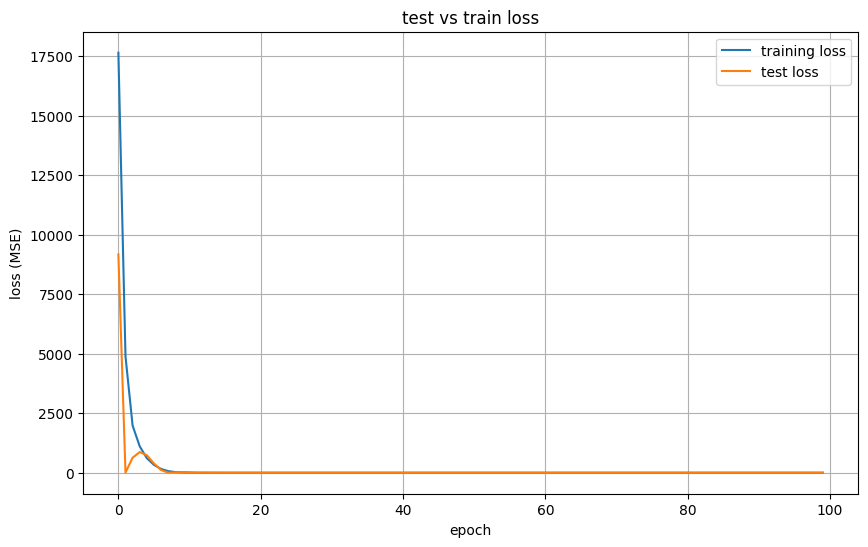

In [4]:
# 训练函数
def train_loop(model, train_loader, optimizer, loss_fn, device, epoch):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    
    for batch_idx, (data, target) in enumerate(pbar):
        # 将数据移至设备
        data, target = data.to(device), target.to(device)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        output = model(data)
        
        # 计算损失
        loss = loss_fn(output, target)
        
        # 反向传播
        loss.backward()
        
        # 更新参数
        optimizer.step()
        
        # 更新总损失
        total_loss += loss.item()
        
        # 更新进度条
        pbar.set_postfix({"loss": total_loss / (batch_idx + 1)})
    
    avg_loss = total_loss / len(train_loader)
    print(f"训练损失: {avg_loss:.6f}")
    return avg_loss

# 测试函数
def test_loop(model, test_loader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for data, target in test_loader:
            # 将数据移至设备
            data, target = data.to(device), target.to(device)
            
            # 前向传播
            output = model(data)
            
            # 计算损失
            loss = loss_fn(output, target)
            
            # 更新总损失
            test_loss += loss.item()
    
    avg_loss = test_loss / len(test_loader)
    print(f"测试损失: {avg_loss:.6f}")
    return avg_loss

# 主函数
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 超参数
    input_dim = 4  # 输入特征数
    hidden_dim = 64
    n_head = 4
    learning_rate = 1e-3
    weight_decay = 1e-4
    num_epochs = 100
    
    # 创建模型
    model = RegressionModel(input_dim, hidden_dim, n_head).to(device)
    
    # 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # 训练历史
    train_losses = []
    test_losses = []
    
    # 训练循环
    for epoch in range(num_epochs):
        train_loss = train_loop(model, train_loader, optimizer, loss_func, device, epoch)
        test_loss = test_loop(model, test_loader, loss_func, device)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        # 这里可以添加早停逻辑
    
    # 绘制训练和测试损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss (MSE)')
    plt.title('test vs train loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')
    
    # 保存模型
    torch.save(model.state_dict(), 'regression_model.pth')
    
    print("训练完成!")

if __name__ == "__main__":
    main()